In [1]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd

%load_ext autoreload
%autoreload 2
import pre_ml
import mlpipeline

In [2]:
covid = pre_ml.data()

print(covid.shape)
covid.head(5)

Requesting data to datos abiertos Mexico
Getting zip raw data into directory, will delete soon
Raw data deleted. If you specified filename, clean data will be saved in data directory
(97326, 21)


,entidad_res,municipio_res,CVE_MUN,embarazo,edad,diabetes,epoc,asma,inmusupr,hipertension,...,obesidad,tabaquismo,pobreza,Densidad_pob,medicos,camas_hosp,enfermeras,hospitalizado,muertos,covid_grave
0,27,13,27013,0.0,27,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,50.5,278.894557,1.272981,0.736989,3.215951,0,0,0
1,14,39,14039,0.0,24,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,25.8,9945.131631,2.248080,25.620134,60.418821,0,0,0
2,9,7,9007,0.0,22,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,36.4,16028.524764,2.170140,7.325600,17.785234,0,0,0
3,25,6,25006,0.0,60,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,31.2,152.715706,2.637944,10.489463,30.502528,1,1,1
4,15,81,15081,0.0,70,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,32.8,3189.048863,0.998831,5.353736,14.562961,1,1,1


In [3]:
print('hospitalizado')
print(covid['hospitalizado'].value_counts())
print('muerto')
print(covid['muertos'].value_counts())
print('covid grave')
print(covid['covid_grave'].value_counts())

hospitalizado
0    63664
1    33662
Name: hospitalizado, dtype: int64
muerto
0    86689
1    10637
Name: muertos, dtype: int64
covid grave
0    62568
1    34758
Name: covid_grave, dtype: int64


# Logistic Regression

Logistic regression is a supervised learning classification algorithm used to predict the probability of a target variable. This is an extension of linear regression whose target prediction is binary. Linear regression assumes that the data follows a linear function, Logistic regression models the data using the sigmoid function.

$$g(z) = \frac{1}{1+e^{-z}}$$

The function maps any real value into another value between 0 and 1. Logistic regression becomes a classification technique after choosing a decision threshold. 

# Predicting Deaths 
(using SMOTE)

The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, then evaluate the model on the stratified but non-transformed test set.

The ideal way to conduct this experiment is to perform oversampling of the training set in each cross-validation iteration, not before beginning the process. This prevents the data leakage from the validation set to the training set during cross-validation, and reflects how the model trained on a balanced training set would perform when applied to an imbalanced, unseen test set.

* In each iteration exclude some data for validation. The excluded data should not be used for feature selection, oversampling and model building.
* Oversample the minority class only in the training set without the data already excluded for validation.
* Repeat K times, where K is number of folds.

This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
This pipeline can then be evaluated using repeated k-fold cross-validation.

In [4]:
#separate training and testing
train, test = mlpipeline.split_data(covid, 0.2, 1)
print(train.shape)

#normalize train and test continous variables
train, test = mlpipeline.normalize(train, test, ['edad', 'pobreza', 'Densidad_pob', 'medicos',
                                                            'camas_hosp', 'enfermeras'])
train[['edad', 'pobreza', 'Densidad_pob', 'medicos','camas_hosp', 'enfermeras']].describe().loc[['mean', 'std'], :]

(77860, 21)


,edad,pobreza,Densidad_pob,medicos,camas_hosp,enfermeras
mean,2.108083e-16,4.977039e-16,8.742614e-17,-3.101894e-16,-1.006587e-16,-1.383943e-16
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00


In [5]:
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
target= ['muertos']

pipeline = make_pipeline((SMOTE(random_state=0)), LogisticRegression(random_state=0))


#model
params = {'logisticregression__penalty': ['l2'],
          'logisticregression__C': [0.01, 0.1, 1, 10, 100],
          'logisticregression__solver': ['lbfgs']}

grid_d = GridSearchCV(estimator=pipeline,
                    param_grid=params,
                    cv=10,
                    return_train_score=True,
                    scoring= ['accuracy', 'precision', 'recall'],
                    refit = 'recall')

grid_d.fit(train[features].values, train[target].values.ravel())
results = pd.DataFrame(grid_d.cv_results_)
results[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]

,params,mean_test_accuracy,mean_test_precision,mean_test_recall
0,"{'logisticregression__C': 0.01, 'logisticregre...",0.721706,0.241282,0.729897
1,"{'logisticregression__C': 0.1, 'logisticregres...",0.721667,0.241156,0.729304
2,"{'logisticregression__C': 1, 'logisticregressi...",0.721667,0.241136,0.729185
3,"{'logisticregression__C': 10, 'logisticregress...",0.721641,0.241117,0.729185
4,"{'logisticregression__C': 100, 'logisticregres...",0.721641,0.241117,0.729185


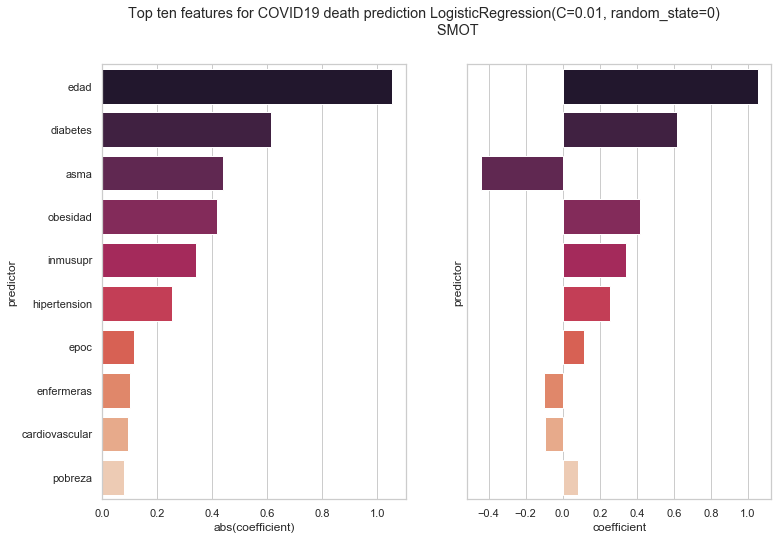

In [6]:
import seaborn as sns

best_model = grid_d.best_estimator_.get_params()['steps'][1][1]

coeffs = pd.DataFrame.from_dict({'predictor':features,
                                 'coefficient':best_model.coef_.flatten(),
                                 'abs_coeffient':abs(best_model.coef_.flatten())})
coeffs.sort_values(by='abs_coeffient', inplace=True,ascending=False)

sns.set(style="whitegrid") 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 8)
plt.suptitle('''Top ten features for COVID19 death prediction {} 
                SMOT'''.format(best_model))

plt.sca(ax[0])
sns.barplot(x="abs_coeffient", y="predictor", data=coeffs[0:10],
            palette="rocket")
ax[0].set_xlabel('abs(coefficient)')

plt.sca(ax[1])
sns.barplot(x="coefficient", y="predictor", data=coeffs[0:10],
            palette="rocket")
plt.setp(ax[1],yticks=[]);

[[12439  4835]
 [  631  1561]]


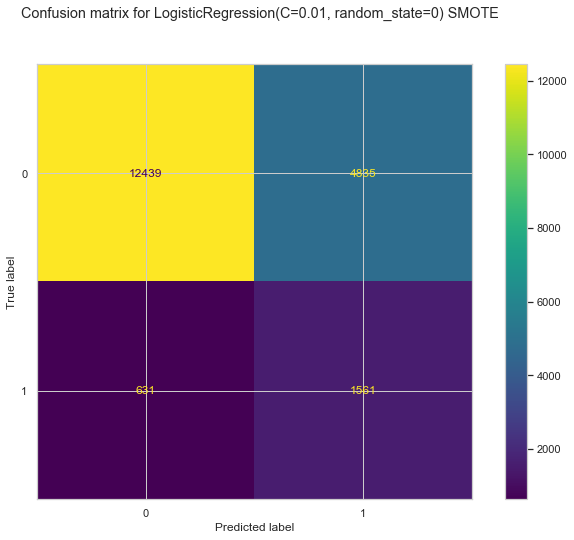

In [7]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

pred = best_model.predict(test[features])

cm = confusion_matrix(test[target],pred)
print(cm)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.suptitle('Confusion matrix for '+str(best_model)+ ' SMOTE');
plot_confusion_matrix(best_model, test[features], test[target], ax=ax);

In [8]:
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(accuracy_score(test[target],pred),
                       precision_score(test[target],pred), 
                       recall_score(test[target],pred),
                       f1_score(test[target],pred)))

Accuracy: 0.7192027124216582
Precision: 0.24405878674171358
Recall: 0.7121350364963503
F1 Score: 0.36353050768514206


# Predicting Hospitalization

In [10]:
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
target= ['hospitalizado']

pipeline = make_pipeline((SMOTE(random_state=0)), LogisticRegression(random_state=0))


#model
params = {'logisticregression__penalty': ['l2'],
          'logisticregression__C': [0.01, 0.1, 1, 10, 100],
          'logisticregression__solver': ['lbfgs']}

grid_h = GridSearchCV(estimator=pipeline,
                    param_grid=params,
                    cv=10,
                    return_train_score=True,
                    scoring= ['accuracy', 'precision', 'recall'],
                    refit = 'recall')

grid_h.fit(train[features].values, train[target].values.ravel())
results = pd.DataFrame(grid_h.cv_results_)
results[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]

,params,mean_test_accuracy,mean_test_precision,mean_test_recall
0,"{'logisticregression__C': 0.01, 'logisticregre...",0.705086,0.561444,0.674549
1,"{'logisticregression__C': 0.1, 'logisticregres...",0.705086,0.561449,0.674438
2,"{'logisticregression__C': 1, 'logisticregressi...",0.705073,0.561451,0.674252
3,"{'logisticregression__C': 10, 'logisticregress...",0.705099,0.561486,0.674252
4,"{'logisticregression__C': 100, 'logisticregres...",0.705099,0.561486,0.674252


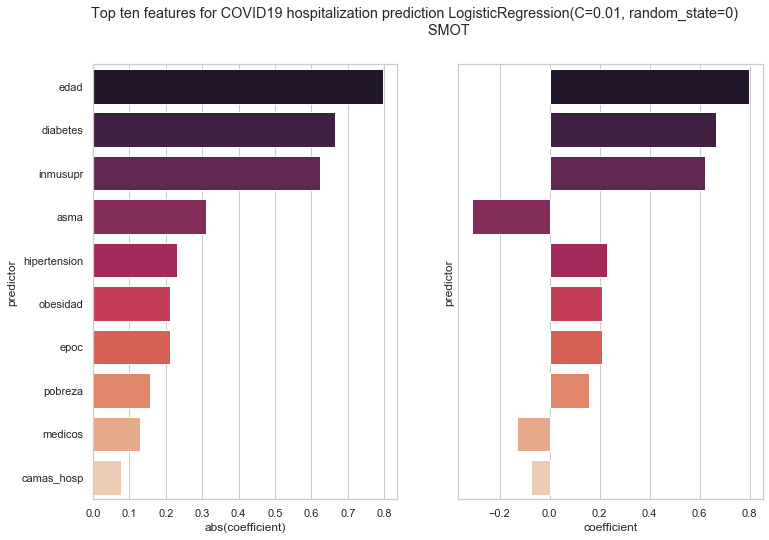

In [11]:
best_model = grid_h.best_estimator_.get_params()['steps'][1][1]

coeffs = pd.DataFrame.from_dict({'predictor':features,
                                 'coefficient':best_model.coef_.flatten(),
                                 'abs_coeffient':abs(best_model.coef_.flatten())})
coeffs.sort_values(by='abs_coeffient', inplace=True,ascending=False)

sns.set(style="whitegrid") 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 8)
plt.suptitle('''Top ten features for COVID19 hospitalization prediction {} 
                SMOT'''.format(best_model))

plt.sca(ax[0])
sns.barplot(x="abs_coeffient", y="predictor", data=coeffs[0:10],
            palette="rocket")
ax[0].set_xlabel('abs(coefficient)')

plt.sca(ax[1])
sns.barplot(x="coefficient", y="predictor", data=coeffs[0:10],
            palette="rocket")
plt.setp(ax[1],yticks=[]);

[[9142 3597]
 [2190 4537]]


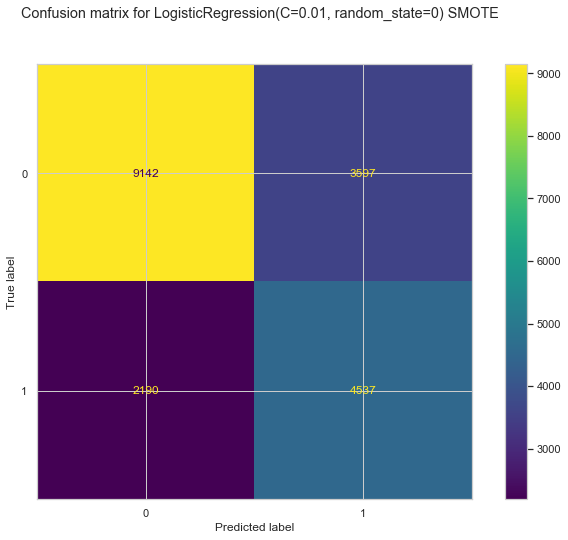

In [12]:
pred = best_model.predict(test[features])

cm = confusion_matrix(test[target],pred)
print(cm)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.suptitle('Confusion matrix for '+str(best_model)+ ' SMOTE');
plot_confusion_matrix(best_model, test[features], test[target], ax=ax);

In [13]:
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(accuracy_score(test[target],pred),
                       precision_score(test[target],pred), 
                       recall_score(test[target],pred),
                       f1_score(test[target],pred)))

Accuracy: 0.702712421658276
Precision: 0.55778214900418
Recall: 0.674446261334919
F1 Score: 0.6105914810578024


# Predicting Hospitalization/Death

In [14]:
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
target= ['covid_grave']

pipeline = make_pipeline((SMOTE(random_state=0)), LogisticRegression(random_state=0))

#model
params = {'logisticregression__penalty': ['l2'],
          'logisticregression__C': [0.01, 0.1, 1, 10, 100],
          'logisticregression__solver': ['lbfgs']}

grid_hm = GridSearchCV(estimator=pipeline,
                    param_grid=params,
                    cv=10,
                    return_train_score=True,
                    scoring= ['accuracy', 'precision', 'recall'],
                    refit = 'recall')

grid_hm.fit(train[features].values, train[target].values.ravel())
log_results = pd.DataFrame(grid_hm.cv_results_)
log_results[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]

,params,mean_test_accuracy,mean_test_precision,mean_test_recall
0,"{'logisticregression__C': 0.01, 'logisticregre...",0.711084,0.581678,0.680489
1,"{'logisticregression__C': 0.1, 'logisticregres...",0.711187,0.581879,0.679985
2,"{'logisticregression__C': 1, 'logisticregressi...",0.711123,0.581815,0.679805
3,"{'logisticregression__C': 10, 'logisticregress...",0.711161,0.581848,0.679949
4,"{'logisticregression__C': 100, 'logisticregres...",0.711161,0.581848,0.679949


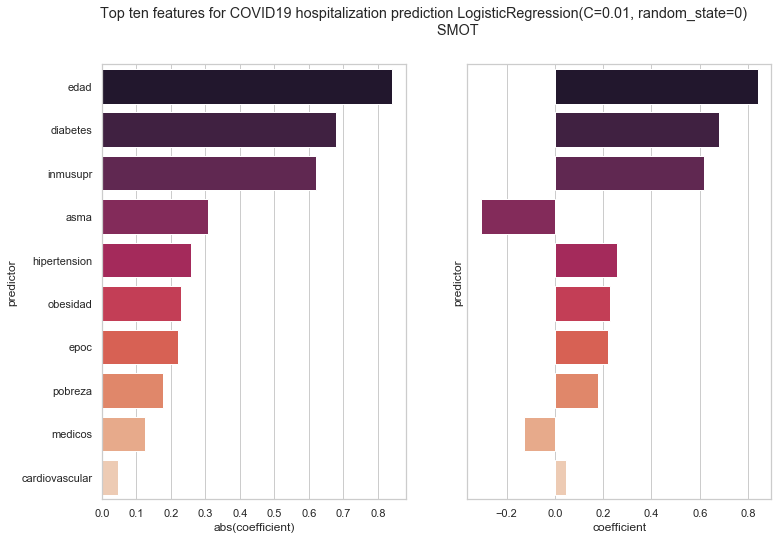

In [15]:
best_model = grid_hm.best_estimator_.get_params()['steps'][1][1]

coeffs = pd.DataFrame.from_dict({'predictor':features,
                                 'coefficient':best_model.coef_.flatten(),
                                 'abs_coeffient':abs(best_model.coef_.flatten())})
coeffs.sort_values(by='abs_coeffient', inplace=True,ascending=False)

sns.set(style="whitegrid") 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 8)
plt.suptitle('''Top ten features for COVID19 hospitalization prediction {} 
                SMOT'''.format(best_model))

plt.sca(ax[0])
sns.barplot(x="abs_coeffient", y="predictor", data=coeffs[0:10],
            palette="rocket")
ax[0].set_xlabel('abs(coefficient)')

plt.sca(ax[1])
sns.barplot(x="coefficient", y="predictor", data=coeffs[0:10],
            palette="rocket")
plt.setp(ax[1],yticks=[]);

[[9054 3459]
 [2230 4723]]


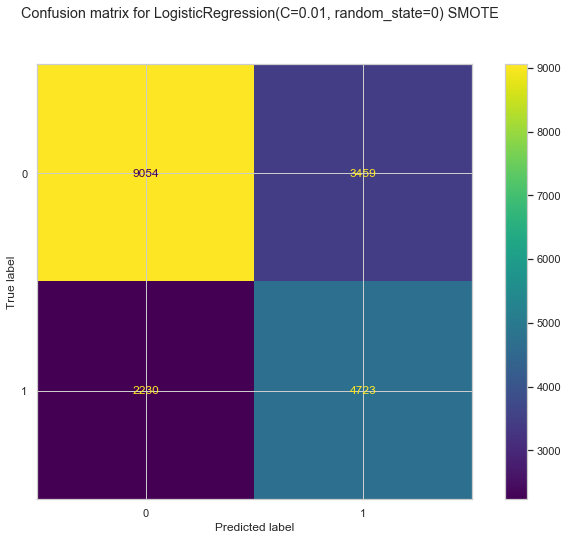

In [16]:
pred = best_model.predict(test[features])

cm = confusion_matrix(test[target],pred)
print(cm)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.suptitle('Confusion matrix for '+str(best_model)+ ' SMOTE');
plot_confusion_matrix(best_model, test[features], test[target], ax=ax);

In [17]:
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(accuracy_score(test[target],pred),
                       precision_score(test[target],pred), 
                       recall_score(test[target],pred),
                       f1_score(test[target],pred)))

Accuracy: 0.7077468406452275
Precision: 0.5772427279393791
Recall: 0.6792751330360995
F1 Score: 0.6241162867525604
